### 类激活的热力图的概念

类激活的热力图：用来显示输入的图像中哪个部分对图像最终的分类判断起到了作用。举个例子来说，比如上面用到的猫狗分类，如果输入的图片是一只猫，那么模型中用到了图片的那些信息（图片的那些区域：猫的头，爪，身体等等）来分类该图片为猫。这里的热力图就用来标记那些有用的区域。为了区分不同区域的作用权重，图中还会通过不同的颜色来显示。

主要的作用：
- 方便我们理解模型是怎么来做判断的
- 出现分类错误，方便用来调试
- 可以定位图像中的特定目标：可以用来考虑目标检测和分割的模型

### Class Activation Mapping理解

具体的理解可以参考论文：[《Learning Deep Features for Discriminative Localization》](http://openaccess.thecvf.com/content_cvpr_2016/papers/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)

相关的论文集参考如下图：
![CAM论文集](imgs/12.jpg)

#### GAP(Global Average Pooling Layer) 全局平均池化层

传统的池化层在模型用来正则化，减少模型维度，从而防止过拟合。用更少的尺寸的特征图来表征数据，保留主要的特征的同时减少计算量和减少参数的数量。
全局平均池化层与其它池化的区别：

![全局平均池化原理](imgs/13.jpg)

全局平均池化层指计算整个区域的平均值，仅用一个值来表示整个区域。具体如下图：

![全局平均池化](imgs/14.jpg)

左边是一个特征图。高度为6，宽度为6，深度为3。当它经过GAP，我们把每一层的参数用一个值表示，这个特征图就变成一个1*1*3的特征向量。

这篇论文发现用GAP代替全连接层，不仅可以降低维度，防止过拟合，减少大量参数，网络的性能也很不错。具体代替如下图：


![全局平均代替全连接层](imgs/15.jpg)

从这里可以看出，这里将最后的最大池化层和全连接层去掉，然后使用全局平均池化代替其，最后的网络就变成了1x1x512的数据，然后在于softmax层相连接。
这样做的好处：
- 最小化参数数量
- 高性能
- 结构简单
- 避免过拟合

缺点：收敛速度慢

**但是论文中指出经过这样的替换后，发现GAP可以用来保留图像空间信息并且可以定位。**

#### CAM类激活的热力图的原理

类激活图仅仅是在不同空间位置处存在这些视觉图案的加权线性和。 通过简单地将类激活映射上采样到输入图像的大小，我们可以识别与特定类别最相关的图像区域。用数学语言解释如下图：

![CAM类激活的热力图的原理](imgs/16.jpg)

GAP就是把特征图转换成特征向量，每一层特征图用一个值表示，所以如果这个特征图的深度是512，那么这个特征向量的长度就是512。我们的输出是Australian terrier，澳大利亚梗。我们用Australian terrier这个类对应的权重乘上特征图对应的层，用热力图归一化，即下面一排热力图：W1\*蓝色层+W2\*红色层+…+Wn\*绿色层=类激活映射（CAM），所以说CAM是一个加权线性和。具体的函数公式如下图：

![CAM数学公式](imgs/17.jpg)

**关于权重W**
 经过上面的公式W加权的特征图集重叠而成的一个特征图,模型做出分类决策的依据来源于W 矩阵。那么如何进行可视化呢？ W矩阵本身只是一堆大小不一的权值而已，并不直观。不过我们可以注意到， W 矩阵对图像的理解基于对特征向量的加权，而特征向量背后是一个个特征图，因此可以跳过特征向量，直接将这些特征图用 W加权，再重叠合成为一张特征图，就可以很直观的看到到底模型是通过看哪片区域来做出判断的。
 
 
![CAM加权W显示](imgs/18.jpg)

详细的coding 如下展示
最终的结果：

![elephant](imgs/elephant.png)

![elephant](imgs/elephant_cam_last.jpg)

In [3]:
from keras.applications.vgg16 import VGG16
from keras import backend as K

model = VGG16(weights = 'imagenet')

In [4]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions 
import numpy as np

img_path = 'imgs/elephant.png'
# 大 小 为 224×224 的 Python图像库（PIL，Python imaginglibrary）图像
img = image.load_img(img_path,target_size=(224,224))
# 形 状 为 (224, 224, 3) 的float32 格式的 Numpy 数组
x = image.img_to_array(img)
# 添加一个维度，将数组转换为(1, 224, 224, 3) 形状的批量
x = np.expand_dims(x,axis = 0)
# 对批量进行预处理（按通道进行颜色标准化）
x = preprocess_input(x)


In [5]:
preds = model.predict(x)
print('Predicted:',decode_predictions(preds,top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.7816769), ('n01871265', 'tusker', 0.20359665), ('n02504013', 'Indian_elephant', 0.014230473)]


In [6]:
np.argmax(preds[0])

386

In [19]:


# 使用 Grad-CAM 算法
#预测向量中的非洲象元素
african_elephant_output = model.output[:, 386]
#得到指定层的输出特征图，这是Vgg16最后一个卷积层
last_conv_layer = model.get_layer('block5_conv3')
# 得到非洲象在block5_conv3输出特征图的梯
grads = K.gradients(african_elephant_output,last_conv_layer.output)[0]
#（512，）的向量，每个元素是特征图通道的梯度平均大小
pooled_grads = K.mean(grads, axis=(0, 1, 2))
#访问pooled_grads：对于给定的样本图像，pooled_grads和block5_conv3层的输出特征图
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

#将特征图数组中的每个通道*这个通道对“大象”类别的重要程度。
for i in range(512):
     conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

#得到特征图的逐个通道平均值即类激活热力图    
heatmap = np.mean(conv_layer_output_value, axis=-1)

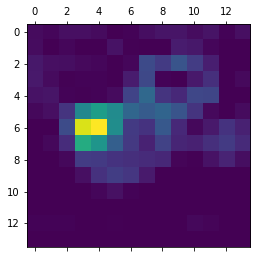

In [20]:
#绘制热力图
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [21]:
# 最后，我们可以用 OpenCV 来生成一张图像，将原始图像叠加在刚刚得到的热力图上
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
# 将热力图应用于原始图像
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# 这里的 0.4 是热力图强度因子
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant_cam_last.jpg', superimposed_img)


True